In [12]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [13]:

# Visualization function
def plot_heatmap(data, title, xlabel, ylabel):
    plt.figure(figsize=(10, 8))
    sns.heatmap(data, annot=True, fmt=".2f", cmap="YlGnBu")
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


# What is Masked Self-Attention?

Masked self-attention is used primarily in the decoder part of transformer models to prevent a position from attending to future positions. This is essential for tasks like language modeling and autoregressive generation, where the model should only consider previous tokens and the current token, effectively preventing it from "peeking" at future tokens.

![mask](../images/decoder.png)

## How Masking Works

When calculating attention scores, we apply a mask to the scores matrix that blocks information from future tokens. The mask can be represented as a binary matrix where a value of 0 indicates that a token can attend to another token, while a value of -∞ (or very large negative value) indicates that a token cannot attend to another token. During the softmax operation, these -∞ values will turn into zero probabilities.

![mask](../images/mask1.png)

## Implementation

1. Setup and Initialize Embeddings

    We'll first define the input embeddings and the weight matrices for queries, keys, and values.

In [14]:

# Hyperparameters
batch_size = 2
sequence_length = 3
embedding_dim = 4
num_heads = 2
head_dim = embedding_dim // num_heads

# Example input: Batch of 2 sequences, each with 3 tokens, embedding dimension of 4
X = torch.randn(batch_size, sequence_length, embedding_dim)
print("Input shape:", X.shape)
print("Input:\n", X)

# Define learned weight matrices for Queries, Keys, and Values
W_q = torch.randn(embedding_dim, embedding_dim)
W_k = torch.randn(embedding_dim, embedding_dim)
W_v = torch.randn(embedding_dim, embedding_dim)
W_o = torch.randn(embedding_dim, embedding_dim)

Input shape: torch.Size([2, 3, 4])
Input:
 tensor([[[ 1.1282,  0.3652, -1.2681,  0.3551],
         [-2.0382,  0.6575,  0.4565,  0.7483],
         [ 0.1241,  0.5851,  0.9884, -1.4534]],

        [[ 0.6070,  1.9327, -0.1870, -1.1787],
         [-0.8092, -0.8550,  2.3611,  0.7676],
         [-1.9986,  0.2764, -0.4084,  0.5942]]])


In [15]:

# Hyperparameters
batch_size = 2
sequence_length = 3
embedding_dim = 4
num_heads = 2
head_dim = embedding_dim // num_heads

# Example input: Batch of 2 sequences, each with 3 tokens, embedding dimension of 4
X = torch.randn(batch_size, sequence_length, embedding_dim)
print("Input shape:", X.shape)
print("Input:\n", X)

# Define learned weight matrices for Queries, Keys, and Values
W_q = torch.randn(embedding_dim, embedding_dim)
W_k = torch.randn(embedding_dim, embedding_dim)
W_v = torch.randn(embedding_dim, embedding_dim)
W_o = torch.randn(embedding_dim, embedding_dim)

Input shape: torch.Size([2, 3, 4])
Input:
 tensor([[[ 0.4204,  1.1198,  0.0990, -0.9208],
         [-0.5481, -0.5406, -1.0397,  1.5864],
         [ 0.7309,  0.3443,  0.9503, -0.3140]],

        [[ 0.0368,  1.1915,  1.2663,  0.2170],
         [-0.1037, -0.0158,  0.6785,  0.4517],
         [ 0.7915,  0.4001, -1.4230, -0.9347]]])


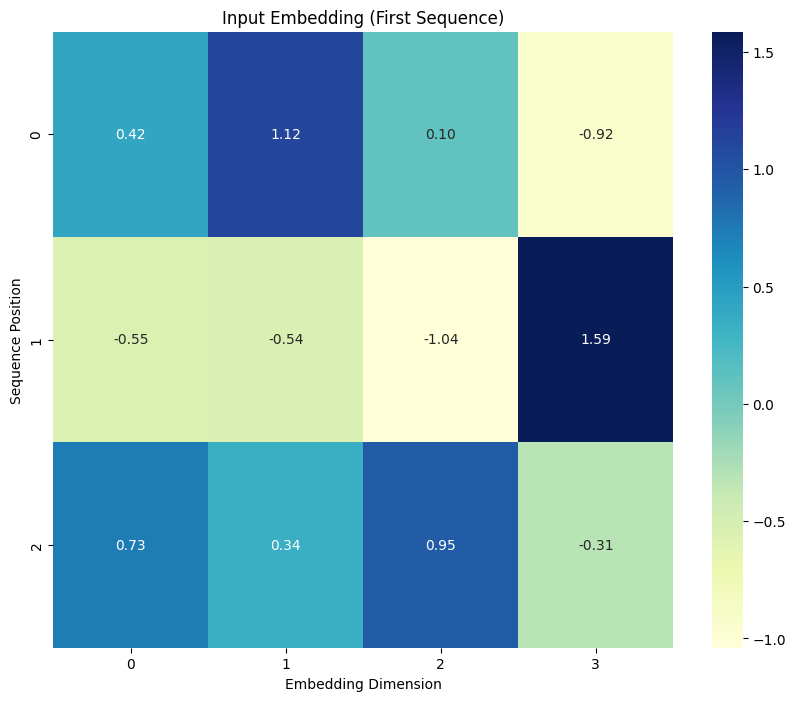

In [16]:
plot_heatmap(X[0].detach().numpy(), "Input Embedding (First Sequence)", "Embedding Dimension", "Sequence Position")


## Linear Projections for Q, K, V:

In this step, we transform the input X into three different representations: queries (Q), keys (K), and values (V). These transformations are done using linear projections (matrix multiplications) with the weight matrices W_q, W_k, and W_v respectively. This process allows the model to extract different aspects of the input that are relevant for attention computation. Each projection captures a different "view" of the input sequence, which is crucial for the attention mechanism to work effectively.

In [17]:
# Calculate Q, K, V matrices
Q = torch.matmul(X, W_q)
K = torch.matmul(X, W_k)
V = torch.matmul(X, W_v)

print("Q shape:", Q.shape)
print("Q:\n", Q)

Q shape: torch.Size([2, 3, 4])
Q:
 tensor([[[-1.3165,  0.0457,  0.6183, -2.1231],
         [ 0.5579,  1.5128, -1.7216,  0.2689],
         [-0.6690, -0.0341,  0.5145,  1.0390]],

        [[-3.8628, -0.0398, -0.4671,  1.3935],
         [-1.0923, -0.1643, -0.3656,  1.8700],
         [ 2.1912,  1.1946,  0.7380, -4.4558]]])


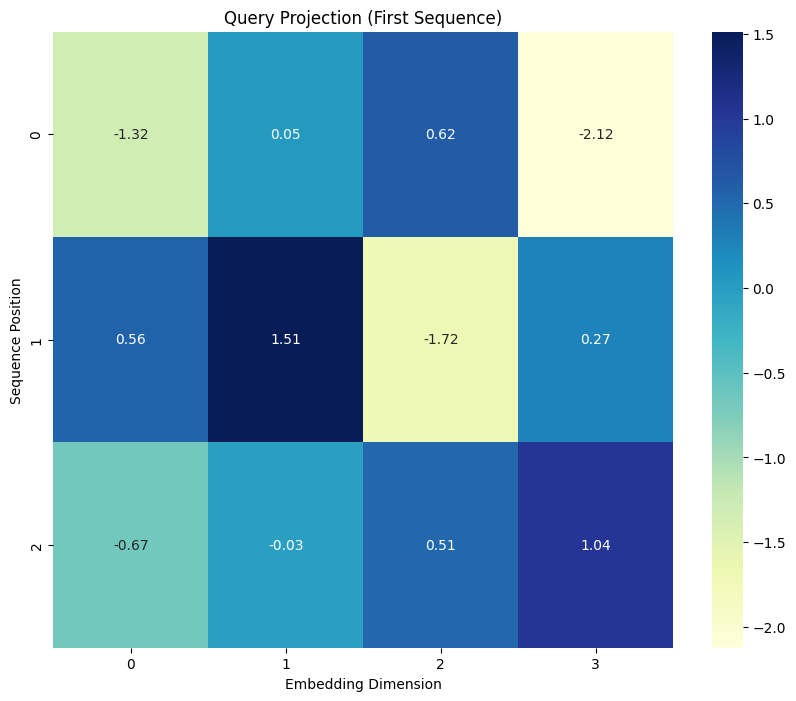

In [18]:
plot_heatmap(Q[0].detach().numpy(), "Query Projection (First Sequence)", "Embedding Dimension", "Sequence Position")


# Reshape for Multi-Head Attention:

The multi-head attention mechanism allows the model to jointly attend to information from different representation subspaces. In this step, we reshape our Q, K, and V tensors to split them into multiple heads. The reshaping operation transforms the tensors from (batch_size, sequence_length, embedding_dim) to (batch_size, num_heads, sequence_length, head_dim). This allows each head to focus on different parts of the embedding space, enabling the model to capture various types of relationships within the data.

In [19]:
# Reshape Q, K, V for multi-head attention
Q = Q.view(batch_size, sequence_length, num_heads, head_dim).transpose(1, 2)
K = K.view(batch_size, sequence_length, num_heads, head_dim).transpose(1, 2)
V = V.view(batch_size, sequence_length, num_heads, head_dim).transpose(1, 2)

print("Reshaped Q shape:", Q.shape)
print("Reshaped Q:\n", Q)

Reshaped Q shape: torch.Size([2, 2, 3, 2])
Reshaped Q:
 tensor([[[[-1.3165,  0.0457],
          [ 0.5579,  1.5128],
          [-0.6690, -0.0341]],

         [[ 0.6183, -2.1231],
          [-1.7216,  0.2689],
          [ 0.5145,  1.0390]]],


        [[[-3.8628, -0.0398],
          [-1.0923, -0.1643],
          [ 2.1912,  1.1946]],

         [[-0.4671,  1.3935],
          [-0.3656,  1.8700],
          [ 0.7380, -4.4558]]]])


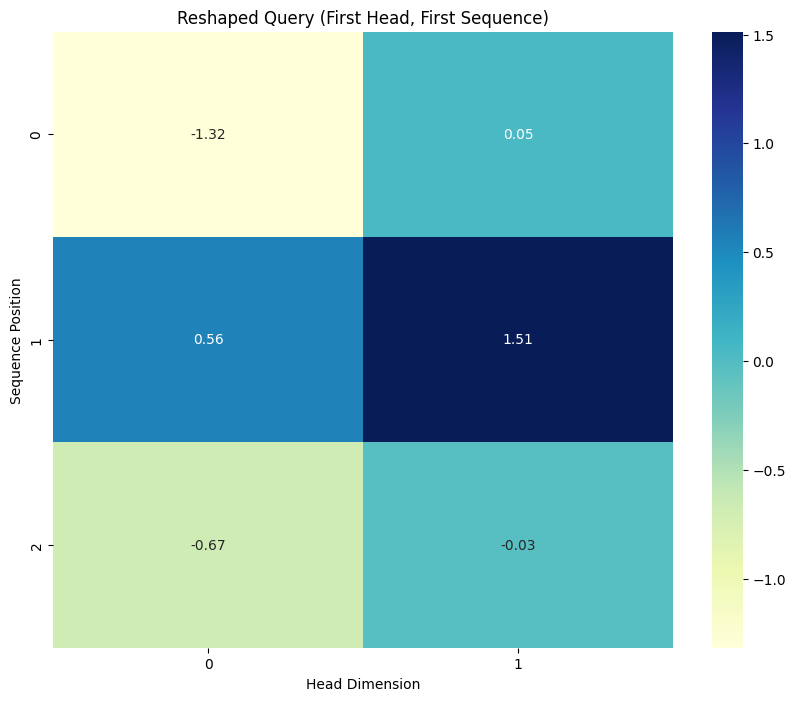

In [20]:
plot_heatmap(Q[0, 0].detach().numpy(), "Reshaped Query (First Head, First Sequence)", "Head Dimension", "Sequence Position")


# Calculate Attention Scores:

This step computes the compatibility between each query and all keys. We calculate the dot product between Q and K for each head, which gives us a measure of how similar or compatible each token (represented by a query) is to every other token (represented by keys) in the sequence. The resulting scores are scaled by the square root of the head dimension to counteract the effect of large values in very high dimensions, which can lead to extremely small gradients during backpropagation.

![mask](../images/qk_mult.png)

In [21]:
# Calculate attention scores
scores = torch.matmul(Q, K.transpose(-2, -1)) / (head_dim ** 0.5)

print("Attention scores shape:", scores.shape)
print("Attention scores:\n", scores)

Attention scores shape: torch.Size([2, 2, 3, 3])
Attention scores:
 tensor([[[[ 1.5970, -2.4107,  2.0863],
          [-1.6553,  2.2274, -2.5949],
          [ 0.8481, -1.2701,  1.1241]],

         [[ 0.7143,  0.0623,  0.7585],
          [-1.3536, -0.1583,  1.2327],
          [ 0.2785,  0.0443, -1.0320]]],


        [[[ 6.8935,  1.5691, -0.6426],
          [ 2.3385,  0.5879, -0.4398],
          [-6.8913, -1.9948,  2.3415]],

         [[-0.9907, -0.1932, -0.0738],
          [-1.3562, -0.4041,  0.1578],
          [ 3.2451,  1.0367, -0.5069]]]])


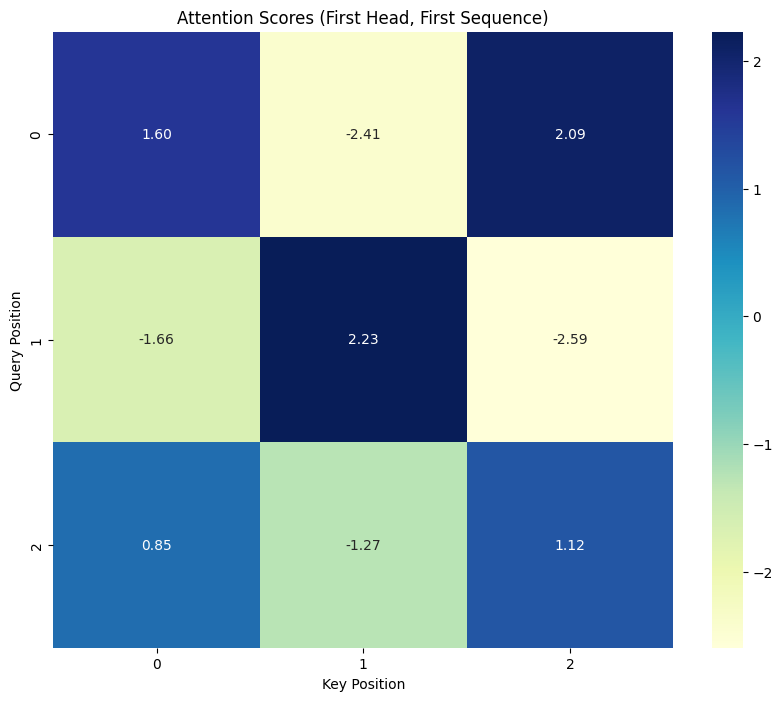

In [22]:
plot_heatmap(scores[0, 0].detach().numpy(), "Attention Scores (First Head, First Sequence)", "Key Position", "Query Position")


# Apply Mask:

Masking is a crucial step in masked self-attention, particularly for applications like language modeling where we want to prevent the model from "cheating" by looking at future tokens. We create a mask that covers the upper triangular part of the attention score matrix. This mask is then applied to the scores by setting the masked positions to negative infinity. When we later apply softmax, these masked positions will effectively receive zero attention, ensuring that each position can only attend to previous positions in the sequence.

![mask](../images/scores.png)

In [23]:
# Create a mask for the upper triangular part of the matrix
mask = torch.triu(torch.ones(sequence_length, sequence_length), diagonal=1).bool()
mask = mask.unsqueeze(0).unsqueeze(0)  # Add batch and head dimensions

# Apply the mask to the attention scores
scores = scores.masked_fill(mask, float('-inf'))

print("Masked attention scores:\n", scores)

Masked attention scores:
 tensor([[[[ 1.5970,    -inf,    -inf],
          [-1.6553,  2.2274,    -inf],
          [ 0.8481, -1.2701,  1.1241]],

         [[ 0.7143,    -inf,    -inf],
          [-1.3536, -0.1583,    -inf],
          [ 0.2785,  0.0443, -1.0320]]],


        [[[ 6.8935,    -inf,    -inf],
          [ 2.3385,  0.5879,    -inf],
          [-6.8913, -1.9948,  2.3415]],

         [[-0.9907,    -inf,    -inf],
          [-1.3562, -0.4041,    -inf],
          [ 3.2451,  1.0367, -0.5069]]]])


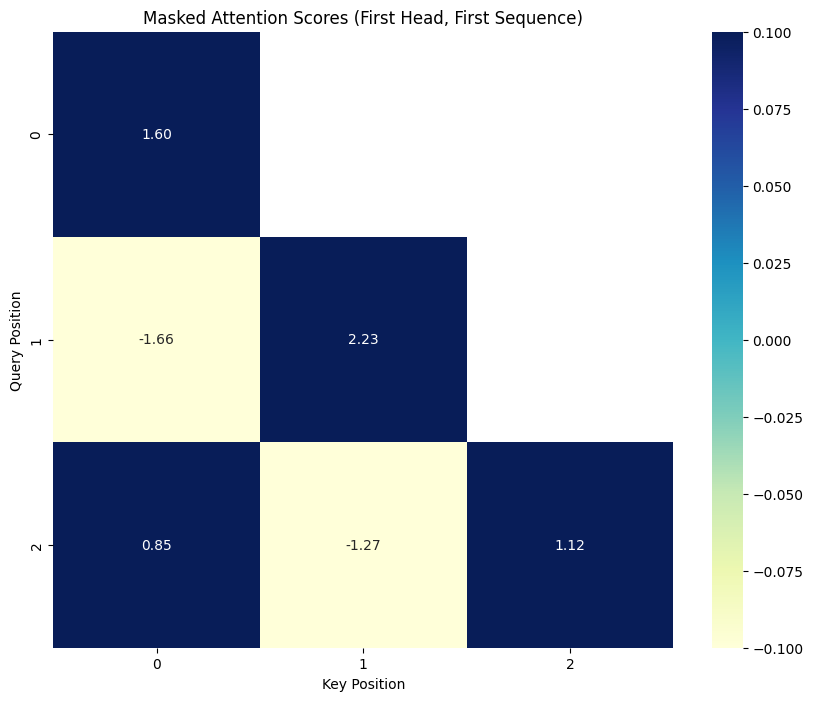

In [24]:
plot_heatmap(scores[0, 0].detach().numpy(), "Masked Attention Scores (First Head, First Sequence)", "Key Position", "Query Position")


# Apply Softmax:

After masking, we apply the softmax function to the attention scores. This step normalizes the scores, converting them into a probability distribution. The softmax operation ensures that the attention weights for each query sum to 1, allowing us to interpret them as the relative importance of each key for a given query. The masking from the previous step ensures that any positions we wanted to ignore (like future tokens) receive zero attention after this softmax operation.

![mask](../images/masked_scores.png)

In [25]:
# Apply softmax to get attention weights
attn_weights = F.softmax(scores, dim=-1)

print("Attention weights shape:", attn_weights.shape)
print("Attention weights:\n", attn_weights)

Attention weights shape: torch.Size([2, 2, 3, 3])
Attention weights:
 tensor([[[[1.0000e+00, 0.0000e+00, 0.0000e+00],
          [2.0179e-02, 9.7982e-01, 0.0000e+00],
          [4.1015e-01, 4.9320e-02, 5.4053e-01]],

         [[1.0000e+00, 0.0000e+00, 0.0000e+00],
          [2.3230e-01, 7.6770e-01, 0.0000e+00],
          [4.8524e-01, 3.8390e-01, 1.3086e-01]]],


        [[[1.0000e+00, 0.0000e+00, 0.0000e+00],
          [8.5202e-01, 1.4798e-01, 0.0000e+00],
          [9.6510e-05, 1.2914e-02, 9.8699e-01]],

         [[1.0000e+00, 0.0000e+00, 0.0000e+00],
          [2.7846e-01, 7.2154e-01, 0.0000e+00],
          [8.8234e-01, 9.6947e-02, 2.0708e-02]]]])


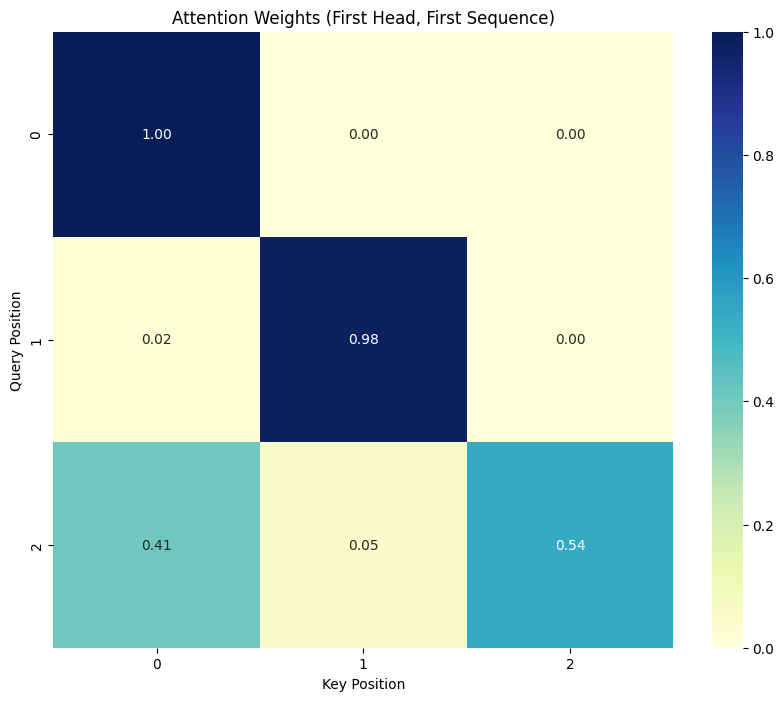

In [26]:
plot_heatmap(attn_weights[0, 0].detach().numpy(), "Attention Weights (First Head, First Sequence)", "Key Position", "Query Position")


# Apply Attention Weights to Values:

In this step, we use the attention weights to compute a weighted sum of the value vectors. This is done by matrix multiplication between the attention weights and the value tensor V. The result is that each position in the output is a sum of values from the input sequence, weighted by how much attention that position pays to each other position. This allows the model to aggregate information from the entire sequence, focusing on the most relevant parts as determined by the attention weights.

In [27]:
# Apply attention weights to values
attn_output = torch.matmul(attn_weights, V)

print("Attention output shape:", attn_output.shape)
print("Attention output:\n", attn_output)

Attention output shape: torch.Size([2, 2, 3, 2])
Attention output:
 tensor([[[[ 0.3678,  4.0300],
          [-0.0180, -3.1847],
          [ 0.1586,  2.2766]],

         [[-0.8501,  1.0087],
          [ 1.1380, -2.3484],
          [ 0.1109, -0.5609]]],


        [[[-0.0198,  3.1126],
          [-0.0478,  2.5856],
          [ 0.6481,  1.9395]],

         [[-2.6542,  3.4494],
          [-1.4231,  1.9780],
          [-2.3894,  3.1083]]]])


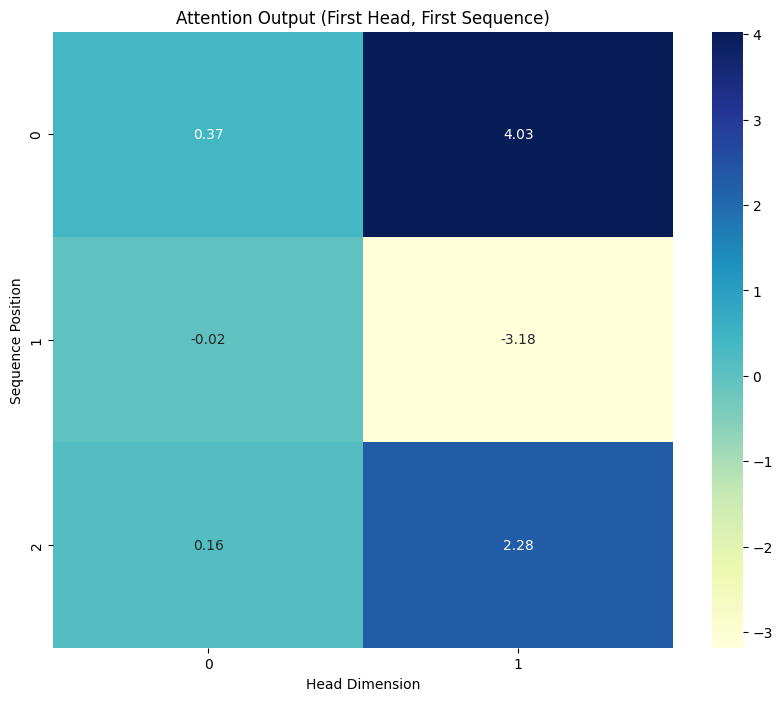

In [28]:
plot_heatmap(attn_output[0, 0].detach().numpy(), "Attention Output (First Head, First Sequence)", "Head Dimension", "Sequence Position")


# Reshape and Project Output:

The final step involves reshaping the attention output back to the original dimensions and applying a final linear projection. We first reshape the output from the multi-head format back to (batch_size, sequence_length, embedding_dim). Then, we apply the output weight matrix W_o, which combines the outputs from all heads into a single representation. This final projection allows the model to integrate information from all attention heads, producing the final output of the self-attention layer.

In [29]:
# Reshape and project output
attn_output = attn_output.transpose(1, 2).contiguous().view(batch_size, sequence_length, embedding_dim)
output = torch.matmul(attn_output, W_o)

print("Final output shape:", output.shape)
print("Final output:\n", output)

Final output shape: torch.Size([2, 3, 4])
Final output:
 tensor([[[ 6.3919,  6.3116,  4.5707,  7.2620],
         [-7.2713, -8.4975, -6.5251, -6.2327],
         [ 1.6036,  0.8971,  0.5644,  3.4051]],

        [[ 9.8433, 12.6633,  8.6514,  7.2068],
         [ 6.3516,  7.8985,  5.5439,  5.2839],
         [ 8.4909,  9.7885,  6.7702,  5.7236]]])


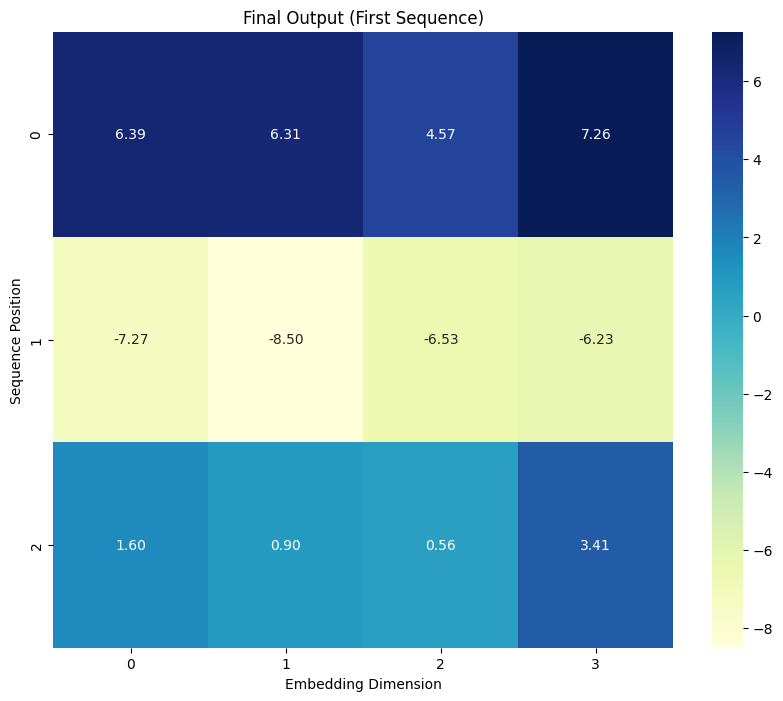

In [30]:
plot_heatmap(output[0].detach().numpy(), "Final Output (First Sequence)", "Embedding Dimension", "Sequence Position")


## Conclusion

In this notebook, we've implemented and visualized the masked self-attention mechanism, a key component of transformer models, particularly in decoder architectures. Let's recap the main steps and their significance:

1. **Input Embedding**: We started with input embeddings, representing tokens in a high-dimensional space.

2. **Linear Projections**: We created separate query, key, and value representations, allowing the model to focus on different aspects of the input for attention computation.

3. **Multi-Head Reshaping**: By reshaping for multiple attention heads, we enabled the model to attend to different parts of the embedding space simultaneously.

4. **Attention Scores**: We computed compatibility between queries and keys, showing how much each token should attend to others.

5. **Masking**: We applied a mask to prevent attending to future tokens, crucial for autoregressive tasks.

6. **Softmax**: This step normalized the scores into a probability distribution, determining the weight of each token's contribution.

7. **Applying Attention**: We used these weights to create a weighted sum of values, effectively aggregating information from the sequence.

8. **Output Projection**: Finally, we combined information from all heads and projected it to the output space.


The visualizations help us understand how information flows and is transformed through the self-attention mechanism. We can see the effect of masking in preventing attention to future tokens and how the attention weights distribute focus across the sequence.

Masked self-attention is a powerful tool that allows models to process sequences while maintaining the autoregressive property, making it invaluable for tasks like language modeling and text generation.